In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

from recnn.preprocessing import rewrite_content
from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

# Plotting functions

In [3]:
def load_tf(filename_train):
    # Make training data
    print("Loading training data...")

    fd = open(filename_train, "rb")
    X, y = pickle.load(fd)
    fd.close()

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(rewrite_content(jet))) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))
    
    return tf

def load_test(tf, filename_test, cropping=True):
    # Make test data 
    print("Loading test data...")

    fd = open(filename_test, "rb")
    X, y = pickle.load(fd)
    fd.close()
    y = np.array(y)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(rewrite_content(jet))) for jet in X]

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
    
    if not cropping:
        return X, y
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    
    # Weights for flatness in pt
    pdf, edges = np.histogram([j["pt"] for j in X], density=True, range=[250, 300], bins=100)
    pts = [j["pt"] for j in X]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
        
    return X, y, inv_w

In [4]:
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated
from recnn.recnn import grnn_predict_simple_join


def predict(X, filename, func=grnn_predict_simple):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return y_pred


def predict_join(X1, X2, filename):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = grnn_predict_simple_join(params, X1, X2)
    return y_pred


def evaluate_models(X, y, w, pattern, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
        
    return rocs, fprs, tprs


def evaluate_models_join(X1, X2, y, w, pattern):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
        y_pred = predict_join(X1, X2, filename)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
        
    return rocs, fprs, tprs

In [5]:
def plot_rocs(rocs, fprs, tprs, label="", color="r"):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    print("%s \t ROC AUC=%.4f+-%.4f \t 1/FPR@TPR=0.5=%.4f+-%.4f)" %  (label, 
                                                                      np.mean(rocs), 
                                                                      np.std(rocs),
                                                                      np.mean(inv_fprs[:, 225]),
                                                                      np.std(inv_fprs[:, 225])))
    
    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

In [6]:
# Count parameters
import pickle

fd = open("../models/jet-study-2/model-w-s-antikt-kt-1.pickle", "rb")
params = pickle.load(fd)
fd.close()

In [20]:
def _count(thing):
    if isinstance(thing, list):
        c = 0
        for stuff in thing:
            c += _count(stuff)
        return c 
    
    elif isinstance(thing, np.ndarray):
        return np.prod(thing.shape)
    
def count(params):
    c = 0
    for k, v in params.items():
        c += _count(v)
    return c
    
count(params)            

8481

# Simple vs gated

In [ ]:
prefix = "antikt-kt"
color = "r"
tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label="RNN-$k_t$ (simple)", color=color)

prefix = "antikt-kt"
color = "b"
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-g-%s-[0-9]*.pickle" % prefix, func=grnn_predict_gated)
plot_rocs(rocs, fprs, tprs, label="RNN-$k_t$ (gated)", color=color)

plot_show("1-simple-vs-gated.pdf")

# Topologies

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


RNN-$k_t$ 	 ROC AUC=0.9191+-0.0006 	 1/FPR@TPR=0.5=69.6191+-2.4701)
Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-cambridge-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-cambridge-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-10.pickle ROC AUC = 0.9205
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-15.pickle ROC AUC = 0.9198
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-27.pickle ROC AUC = 0.9200
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-21.pickle ROC AUC = 0.9205
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-14.pickle ROC AUC = 0.9202
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-28.pickle ROC AUC = 0.9203
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-12.pickle ROC AUC = 0.9199
Loading ../models/jet-study-2/model

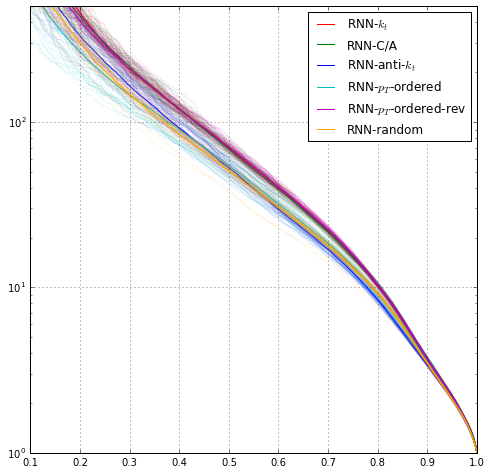

In [10]:
for prefix, label, color in [("antikt-kt", "RNN-$k_t$", "r"), 
                             ("antikt-cambridge", "RNN-C/A", "g"),
                             ("antikt-antikt", "RNN-anti-$k_t$", "b"), 
                             ("antikt-seqpt", "RNN-$p_T$-ordered", "c"),
                             ("antikt-seqpt-reversed", "RNN-$p_T$-ordered-rev", "m"),
                             ("antikt-random", "RNN-random", "orange")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
    plot_rocs(rocs, fprs, tprs, label=label, color=color)

plot_show("2-topology-particles.pdf")

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 29414
	y size = 29414
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-17.pickle ROC AUC = 0.8812
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-16.pickle ROC AUC = 0.8804
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-12.pickle ROC AUC = 0.8813
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-10.pickle ROC AUC = 0.8828
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-9.pickle ROC AUC = 0.8810
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-5.pickle ROC AUC = 0.8827
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-2.pickle ROC AUC = 0.8791
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-25.pickle ROC AUC = 0.8820
Loading ../m

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


	filename = ../data/w-vs-qcd/final/antikt-cambridge-delphes-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-cambridge-delphes-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 29414
	y size = 29414
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-16.pickle ROC AUC = 0.8851
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-15.pickle ROC AUC = 0.8855
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-11.pickle ROC AUC = 0.8836
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-4.pickle ROC AUC = 0.8839
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-10.pickle ROC AUC = 0.8831
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-29.pickle ROC AUC = 0.8841
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-delphes-2.pickle ROC AUC = 0.8846
Loading ../models/jet-study-2/model-w-s-antikt-cambridge-d

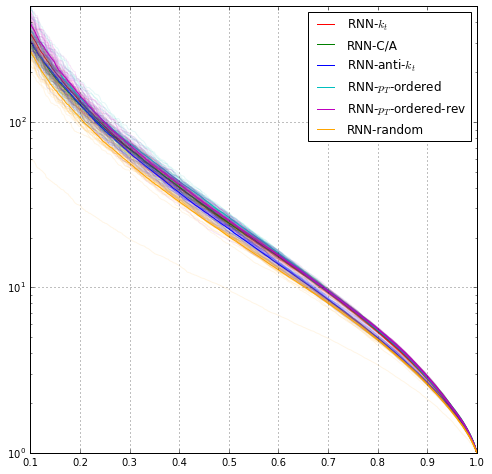

In [9]:
for prefix, label, color in [("antikt-kt-delphes", "RNN-$k_t$", "r"), 
                             ("antikt-cambridge-delphes", "RNN-C/A", "g"),
                             ("antikt-antikt-delphes", "RNN-anti-$k_t$", "b"), 
                             ("antikt-seqpt-delphes", "RNN-$p_T$-ordered", "c"),
                             ("antikt-seqpt-reversed-delphes", "RNN-$p_T$-ordered-rev", "m"),
                             ("antikt-random-delphes", "RNN-random", "orange")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
    plot_rocs(rocs, fprs, tprs, label=label, color=color)

plot_show("2-topology-towers.pdf")

# Particle vs Delphes vs images

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


particles 	 ROC AUC=0.9191+-0.0006 	 1/FPR@TPR=0.5=69.6191+-2.4701)
Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 29414
	y size = 29414
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-17.pickle ROC AUC = 0.8812
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-16.pickle ROC AUC = 0.8804
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-12.pickle ROC AUC = 0.8813
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-10.pickle ROC AUC = 0.8828
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-9.pickle ROC AUC = 0.8810
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-5.pickle ROC AUC = 0.8827
Loading ../models/jet-study-2/model-w-s-antikt-kt-delphes-2.pickle ROC AUC = 0.8791
Loading ../models/jet-study-2

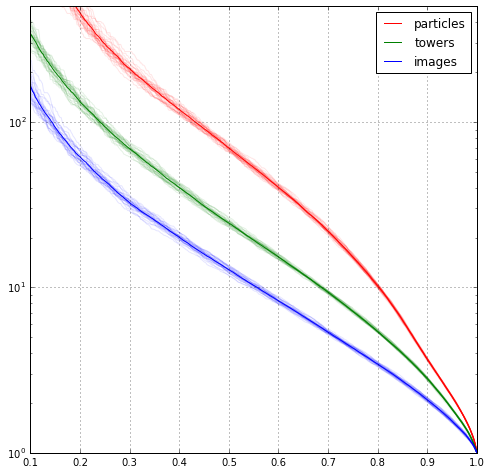

In [19]:
for prefix, label, color in [("antikt-kt", "particles", "r"), 
                             ("antikt-kt-delphes", "towers", "g"), 
                             ("antikt-kt-images", "images", "b")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
    plot_rocs(rocs, fprs, tprs, label=label, color=color)

plot_show("3-particles-towers-images.pdf")

# Trimming

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-trimmed-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 24931
	y size = 24931
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.8967
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.8929
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.8981
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.8926
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.8974
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.8997
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.8977
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.8964
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9013
Loading ../models/jet-study-2/mode

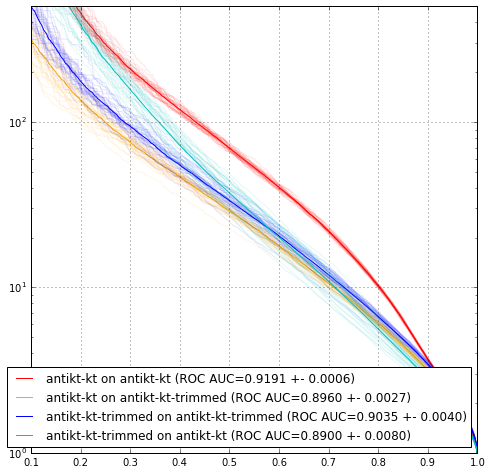

In [8]:
for prefix1, prefix2, color in [("antikt-kt", "antikt-kt", "r"), 
                                ("antikt-kt", "antikt-kt-trimmed", "orange"),
                                ("antikt-kt-trimmed", "antikt-kt-trimmed", "b"),
                                ("antikt-kt-trimmed", "antikt-kt", "c")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix1)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix2) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix1)
    plot_rocs(rocs, fprs, tprs, label="%s on %s" % (prefix1, prefix2), color=color)

plot_show()

# Colinear splits

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-colinear1-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9184
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9179
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9184
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9188
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9196
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9191
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9194
Loading ../models/jet-study-2/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-23.pickle ROC 

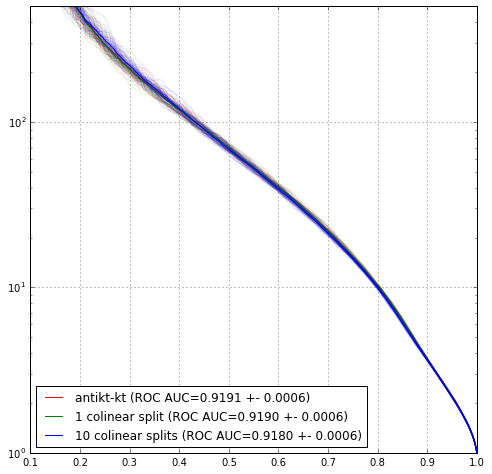

In [9]:
prefix = "antikt-kt"
color = "r"
tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

color = "g"
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % "antikt-kt-colinear1") 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label="1 colinear split", color=color)

color = "b"
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % "antikt-kt-colinear10") 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label="10 colinear splits", color=color)

plot_show()

In [10]:
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-test.pickle", cropping=False) 
y_pred1 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear1-test.pickle", cropping=False) 
y_pred2 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-colinear10-test.pickle", cropping=False) 
y_pred3 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")

Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-colinear1-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-colinear10-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...


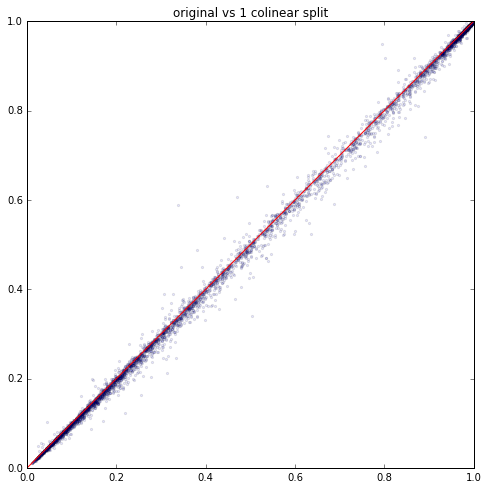

In [11]:
plt.title("original vs 1 colinear split")
plt.scatter(y_pred1, y_pred2, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

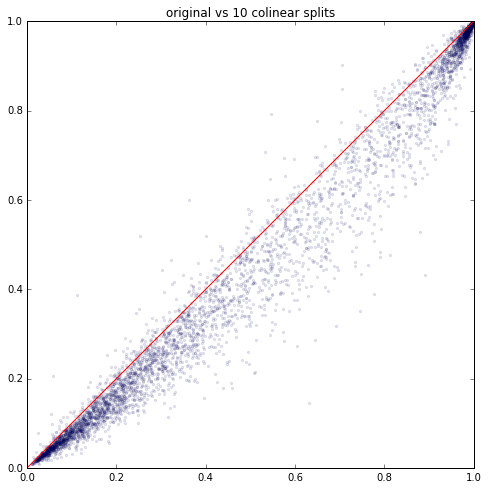

In [12]:
plt.title("original vs 10 colinear splits")
plt.scatter(y_pred1, y_pred3, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

# Soft particles

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37972
	y size = 37972
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


	filename = ../data/w-vs-qcd/final/antikt-kt-soft-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
	X size = 37974
	y size = 37974
Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9178
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9178
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9183
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9184
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9188
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9188
Loading ../models/jet-study-2/model-w-s-antikt-kt-23.pickle ROC AUC = 0.9196
Loading ../mo

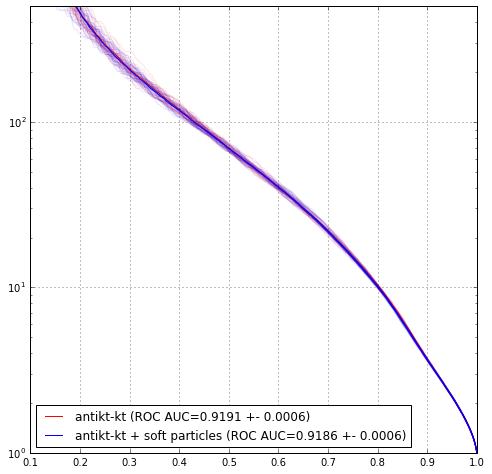

In [13]:
prefix = "antikt-kt"
color = "r"
tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

color = "b"
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % "antikt-kt-soft") 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label="antikt-kt + soft particles", color=color)

plot_show()

In [14]:
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-test.pickle", cropping=False) 
y_pred1 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")
X, y = load_test(tf, "../data/w-vs-qcd/final/antikt-kt-soft-test.pickle", cropping=False) 
y_pred2 = predict(X[:5000], "../models/jet-study-2/model-w-s-antikt-kt-1.pickle")

Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-soft-test.pickle
	X size = 100000
	y size = 100000
Preprocessing...


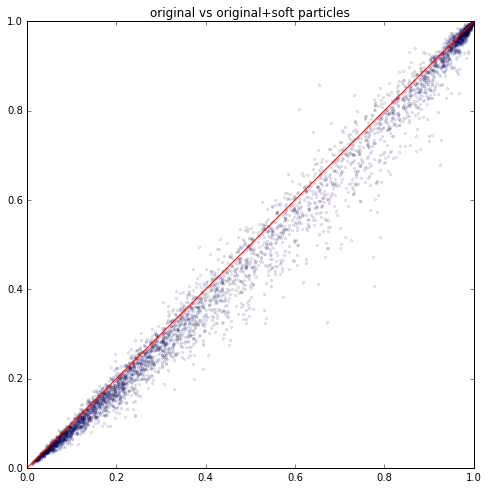

In [15]:
plt.title("original vs original+soft particles")
plt.scatter(y_pred1, y_pred2, marker=".", alpha=0.1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), "r")
plt.show()

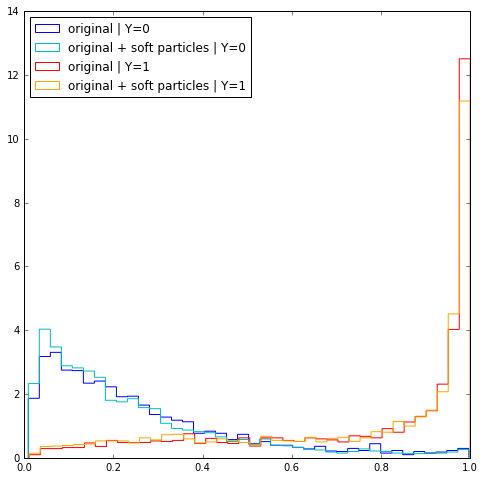

In [29]:
y_ = y[:5000]
_, r, _ = plt.hist(y_pred1[y_ == 0], bins=40, histtype="step", normed=1, color="b", label="original | Y=0")
plt.hist(y_pred2[y_ == 0], bins=r, histtype="step", normed=1, color="c", label="original + soft particles | Y=0")
_, r, _ = plt.hist(y_pred1[y_ == 1], bins=40, histtype="step", normed=1, color="r", label="original | Y=1")
plt.hist(y_pred2[y_ == 1], bins=r, histtype="step", normed=1, color="orange", label="original + soft particles | Y=1")
plt.legend(loc="upper left")
plt.show()

# Stereo

Loading ../models/jet-study-2/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9181
Loading ../models/jet-study-2/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9189
Loading ../models/jet-study-2/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9186
Loading ../models/jet-study-2/model-w-s-antikt-kt-29.pickle ROC AUC = 0.9190
Loading ../models/jet-study-2/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9197
Loading ../models/jet-study-2/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9195
Loading ../models/jet-study-2/model-w-s-antikt-kt-22.pickle ROC AUC = 0.9192
Loading ../models/jet-study-2/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9196
Loading ../models/jet-study-2/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9193
Loading ../models/jet-study-2/model-w-s-antikt-kt-23.pickle ROC AUC = 0.9201
Loading ../models/jet-study-2/model-w-s-antikt-kt-27.pickle ROC AUC = 0.9180
Loading ../models/jet-study-2/model-w-s-antikt-kt-25.pickle ROC AUC = 0.9201
Load

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


Loading ../models/jet-study-2/model-w-s-antikt-antikt-12.pickle ROC AUC = 0.9093
Loading ../models/jet-study-2/model-w-s-antikt-antikt-25.pickle ROC AUC = 0.9108
Loading ../models/jet-study-2/model-w-s-antikt-antikt-23.pickle ROC AUC = 0.9084
Loading ../models/jet-study-2/model-w-s-antikt-antikt-7.pickle ROC AUC = 0.9110
Loading ../models/jet-study-2/model-w-s-antikt-antikt-15.pickle ROC AUC = 0.9112
Loading ../models/jet-study-2/model-w-s-antikt-antikt-3.pickle ROC AUC = 0.9130
Loading ../models/jet-study-2/model-w-s-antikt-antikt-26.pickle ROC AUC = 0.9102
Loading ../models/jet-study-2/model-w-s-antikt-antikt-6.pickle ROC AUC = 0.9119
Loading ../models/jet-study-2/model-w-s-antikt-antikt-19.pickle ROC AUC = 0.9117
Loading ../models/jet-study-2/model-w-s-antikt-antikt-10.pickle ROC AUC = 0.9091
Loading ../models/jet-study-2/model-w-s-antikt-antikt-20.pickle ROC AUC = 0.9086
Loading ../models/jet-study-2/model-w-s-antikt-antikt-28.pickle ROC AUC = 0.9119
Loading ../models/jet-study-2/m

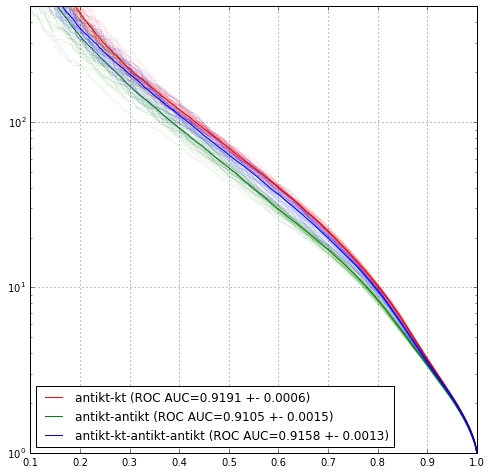

In [12]:
prefix = "antikt-kt"
color = "r"
tf1 = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X1, y1, w1 = load_test(tf1, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X1, y1, w1, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

prefix = "antikt-antikt"
color = "g"
tf2 = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X2, y2, w2 = load_test(tf2, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X2, y2, w2, "../models/jet-study-2/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

prefix = "antikt-kt-antikt-antikt"
color = "b"
rocs, fprs, tprs = evaluate_models_join(X1, X2, y1, w1, "../models/jet-study-2/model-w-ss-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

plot_show()